In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))


2025-04-17 14:18:09.117939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744879689.163529    5888 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744879689.176760    5888 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744879689.269943    5888 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744879689.269965    5888 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744879689.269967    5888 computation_placer.cc:177] computation placer alr

2.19.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import multiprocessing
import gc

data_cfg = {
    'Input_param_names': ['ambient',
                          'coolant',
                          'u_d',
                          'u_q',
                          'motor_speed',
                          #'torque',
                          'i_d',
                          'i_q'
                           ],
    'Target_param_names': ['pm',
                           'stator_yoke',
                           'stator_tooth',
                           'stator_winding'
                          ],
    # for ewm and statistical moments
    'downsample_rate': 1,
    'rolling_lookback': [120,600,3600,7200],
    'valset' : [78, 79, 81],
    'testset' : [27, 29, 30, 31, 65, 72, 4,  5,  6],
    'loss': 'mse',
    # profile ids to drop (don't need to actually exist)

    # paths
    'file_path': "measures.csv",
    'db_path': 'results.db',
    'model_dump_path': 'output/',
    'save_predictions': True,
    'random_seed': 2019,
    'downsample_val_test': True,
    'db_target_scheme': ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding'],
}

# Load dataset
path = 'measures.csv'
conversion_table = {col: np.float32 for col in data_cfg['Input_param_names'] + data_cfg['Target_param_names']}
conversion_table.update({'profile_id': np.uint8})
dataset = pd.read_csv(path, dtype=conversion_table)

# Select relevant columns
x_cols = data_cfg['Input_param_names']
y_cols = data_cfg['Target_param_names']
dataset = dataset.loc[:, x_cols + y_cols + ['profile_id']]                              

# Standardize the data
scaler = StandardScaler()
float_cols = x_cols + y_cols
# Convert columns to float before scaling
dataset[float_cols] = scaler.fit_transform(dataset[float_cols].astype(float))

# Create extra features
def calculate_i_s(row):
    return np.sqrt(row['i_d']**2 + row['i_q']**2)

def calculate_u_s(row):
    return np.sqrt(row['u_d']**2 + row['u_q']**2)

def calculate_P_el(row):
    return row['i_s'] * row['u_s']

if set(['i_d', 'i_q', 'u_d', 'u_q']).issubset(set(dataset.columns.tolist())):
    dataset['i_s'] = dataset.apply(calculate_i_s, axis=1)
    dataset['u_s'] = dataset.apply(calculate_u_s, axis=1)
    dataset['P_el'] = dataset.apply(calculate_P_el, axis=1)

# Function to create lag features
def create_lag_features(args):
    df, lookback = args
    dfs = []
    for lback in range(lookback, lookback + 1, lookback):
        lag_feats = [
            df.shift(lback).astype(np.float32).fillna(df.iloc[0, :]).add_suffix(f'_lag_{lback}'),
            df.diff(periods=lback).astype(np.float32).fillna(df.iloc[0, :]).add_suffix(f'_lag_{lback}_diff')
        ]
        lag_feats += [
            abs(lag_feats[1]).astype(np.float32).add_suffix('_abs'),
            pd.DataFrame(df.values + lag_feats[0].values, columns=df.columns).add_suffix(f'_sum')
        ]
        dfs.append(pd.concat(lag_feats, axis=1))
    return pd.concat(dfs, axis=1)

# Function to create rolling features
def create_rolling_features(args):
    df, lookbacks = args
    dfs = []
    for lookback in lookbacks:
        dummy = np.zeros((lookback, len(df.columns)))
        dummy = pd.DataFrame(dummy, columns=df.columns)
        df = pd.concat([dummy, df], axis=0, ignore_index=True)
        ew_mean = pd.concat([df.ewm(span=lookback).mean().astype(np.float32).rename(columns=lambda c: c + '_ew_rolling_mean_' + str(lookback))], axis=1)
        ew_std = pd.concat([df.ewm(span=lookback).std().astype(np.float32).rename(columns=lambda c: c + '_ew_rolling_std_' + str(lookback))], axis=1)
        dfs.append(pd.concat([ew_mean, ew_std], axis=1).iloc[lookback + 1:, :].reset_index(drop=True))
    return pd.concat(dfs, axis=1)

# Apply feature creation in parallel
profiles_df = [dataset.loc[dataset['profile_id'] == int(p), :].reset_index(drop=True) for p in dataset['profile_id'].unique().tolist()]
num_cores = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cores) as pool:
    lag_feats = pool.map(create_lag_features, [(df, data_cfg['downsample_rate']) for df in profiles_df])
    rolling_feats = pool.map(create_rolling_features, [(df, data_cfg['rolling_lookback']) for df in profiles_df])

# Merge features together
merged_profiles_df = [pd.concat([df] + [lag_feats[i], rolling_feats[i]], axis=1) for i, df in enumerate(profiles_df)]
dataset = pd.concat(merged_profiles_df, axis=0, ignore_index=True)

# Clean up
gc.collect()

# Save or return the processed dataset
dataset.to_csv('processed_dataset_base.csv', index=False)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError

# Custom MSE metric
def mse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Load dataset
dataset = pd.read_csv('processed_dataset_base.csv')

# Define validation and test profile IDs
valset = [78, 79, 81]
testset = [27, 29, 30, 31, 65, 72, 4,  5,  6]

# Split dataset
train_profiles = dataset[~dataset['profile_id'].isin(valset + testset)]
val_profiles = dataset[dataset['profile_id'].isin(valset)]
test_profiles = dataset[dataset['profile_id'].isin(testset)]

y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

# **Filter out target-prefixed columns from x_cols**
def remove_prefixed_columns(x_cols, y_cols):
    """ Remove columns with prefixes matching y_cols """
    y_prefixes = tuple(f"{col}_" for col in y_cols)  # Add trailing underscore for prefix match
    return [col for col in x_cols if not col.startswith(y_prefixes)]

# Identify x_cols, excluding targets and profile_id
x_cols = dataset.columns[~dataset.columns.isin(y_cols + ['profile_id'])].tolist()
x_cols = remove_prefixed_columns(x_cols, y_cols)  # Remove prefixed columns

print("Final x_cols after prefix filtering:", x_cols)


Final x_cols after prefix filtering: ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q', 'i_s', 'u_s', 'P_el', 'ambient_lag_1', 'coolant_lag_1', 'u_d_lag_1', 'u_q_lag_1', 'motor_speed_lag_1', 'i_d_lag_1', 'i_q_lag_1', 'profile_id_lag_1', 'i_s_lag_1', 'u_s_lag_1', 'P_el_lag_1', 'ambient_lag_1_diff', 'coolant_lag_1_diff', 'u_d_lag_1_diff', 'u_q_lag_1_diff', 'motor_speed_lag_1_diff', 'i_d_lag_1_diff', 'i_q_lag_1_diff', 'profile_id_lag_1_diff', 'i_s_lag_1_diff', 'u_s_lag_1_diff', 'P_el_lag_1_diff', 'ambient_lag_1_diff_abs', 'coolant_lag_1_diff_abs', 'u_d_lag_1_diff_abs', 'u_q_lag_1_diff_abs', 'motor_speed_lag_1_diff_abs', 'i_d_lag_1_diff_abs', 'i_q_lag_1_diff_abs', 'profile_id_lag_1_diff_abs', 'i_s_lag_1_diff_abs', 'u_s_lag_1_diff_abs', 'P_el_lag_1_diff_abs', 'ambient_sum', 'coolant_sum', 'u_d_sum', 'u_q_sum', 'motor_speed_sum', 'i_d_sum', 'i_q_sum', 'profile_id_sum', 'i_s_sum', 'u_s_sum', 'P_el_sum', 'ambient_ew_rolling_mean_120', 'coolant_ew_rolling_mean_120', 'u_d_ew_rolli

In [4]:

X_train, y_train = train_profiles[x_cols].values, train_profiles[y_cols].values
X_val, y_val = val_profiles[x_cols].values, val_profiles[y_cols].values
X_test, y_test = test_profiles[x_cols].values, test_profiles[y_cols].values

# Lookback window
# lookback = 10  
lookback = 128

# Reshape function for CNN
def reshape_data(X, y, lookback):
    num_samples = (X.shape[0] // lookback) * lookback
    X, y = X[:num_samples], y[:num_samples]
    X = X.reshape((num_samples // lookback, lookback, X.shape[1]))  # (batch, time_steps, features)
    y = y[lookback - 1::lookback]  
    return X, y

X_train, y_train = reshape_data(X_train, y_train, lookback)
X_val, y_val = reshape_data(X_val, y_val, lookback)
X_test, y_test = reshape_data(X_test, y_test, lookback)

In [5]:
import numpy as np

print("NaN in X_train:", np.isnan(X_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("Inf in X_train:", np.isinf(X_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())


NaN in X_train: 34482810
NaN in y_train: 9308
Inf in X_train: 0
Inf in y_train: 0


In [6]:
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

print("NaN in X_train:", np.isnan(X_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("Inf in X_train:", np.isinf(X_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())

NaN in X_train: 0
NaN in y_train: 0
Inf in X_train: 0
Inf in y_train: 0


In [7]:
print("NaNs in X_val:", np.isnan(X_val).sum())
print("NaNs in y_val:", np.isnan(y_val).sum())

NaNs in X_val: 44
NaNs in y_val: 0


In [8]:
X_val = np.nan_to_num(X_val)  # Replace NaNs with 0
y_val = np.nan_to_num(y_val)
print("NaNs in X_val:", np.isnan(X_val).sum())
print("NaNs in y_val:", np.isnan(y_val).sum())

NaNs in X_val: 0
NaNs in y_val: 0


In [9]:
print("NaNs in X_test:", np.isnan(X_test).sum())
print("NaNs in y_val:", np.isnan(y_val).sum())

NaNs in X_test: 176
NaNs in y_val: 0


In [10]:
X_test = np.nan_to_num(X_test)  # Replace NaNs with 0
y_test = np.nan_to_num(y_test)
print("NaNs in X_test:", np.isnan(X_test).sum())
print("NaNs in y_test:", np.isnan(y_test).sum())

NaNs in X_test: 0
NaNs in y_test: 0


In [11]:
X_train.shape

(10401, 128, 142)

In [12]:
y_train.shape

(10401, 4)

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, LSTM, TimeDistributed, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def tft_block(inputs, block_id, num_heads=4, d_model=128, dropout_rate=0.2, l2_reg=1e-4):
    x = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, name=f"attention_layer_{block_id}")(inputs, inputs)
    x = Dropout(dropout_rate, name=f"dropout_1_{block_id}")(x)
    x = LayerNormalization(epsilon=1e-6, name=f"layernorm_1_{block_id}")(x)

    x = LSTM(units=128, return_sequences=True, name=f"lstm_{block_id}", kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate, name=f"dropout_2_{block_id}")(x)
    x = LayerNormalization(epsilon=1e-6, name=f"layernorm_2_{block_id}")(x)

    return x

def build_tft(seq_len, num_features, num_heads=4, d_model=128, dropout_rate=0.2, l2_reg=1e-4):
    inputs = Input(shape=(seq_len, num_features), name="inputs")

    x = tft_block(inputs, block_id=1, num_heads=num_heads, d_model=d_model, dropout_rate=dropout_rate, l2_reg=l2_reg)
    x = tft_block(x, block_id=2, num_heads=num_heads, d_model=d_model, dropout_rate=dropout_rate, l2_reg=l2_reg)

    x = TimeDistributed(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)), name="td_dense_1")(x)
    x = Dropout(dropout_rate, name="dropout_dense")(x)
    x = TimeDistributed(Dense(4, kernel_regularizer=l2(l2_reg)), name="td_dense_2")(x)

    outputs = GlobalAveragePooling1D(name="global_avg_pooling")(x)

    model = Model(inputs=inputs, outputs=outputs, name="TFT_Model")
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mse']
    )
    return model


In [14]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
# tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Assuming X_train, y_train, X_val, y_val are already prepared
seq_len, num_features = X_train.shape[1], X_train.shape[2]
tft_model = build_tft(seq_len, num_features)

# Print model summary
tft_model.summary()

# Path to save the best model
checkpoint_path = "best_tft_model.h5"

# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=30, verbose=1),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,        # Save only the best model
        save_weights_only=False,    # Save the entire model (architecture + weights)
        verbose=1
    )
]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(1024).batch(128).prefetch(tf.data.AUTOTUNE)


# Train the model
history = tft_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)


I0000 00:00:1744879986.567256    5888 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3734 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "TFT_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 128, 142)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_1   │ (None, 128, 142)  │    292,494 │ inputs[0][0],     │
│ (MultiHeadAttentio… │                   │            │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 128, 142)  │          0 │ attention_layer_… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layernorm_1_1       │ (None, 128, 142)  │        284 │ dropout_1_1[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128, 128)  │    138,752 │ layernorm_1_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 128, 128)  │          0 │ lstm_1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layernorm_2_1       │ (None, 128, 128)  │        256 │ dropout_2_1[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_2   │ (None, 128, 128)  │    263,808 │ layernorm_2_1[0]… │
│ (MultiHeadAttentio… │                   │            │ layernorm_2_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_2         │ (None, 128, 128)  │          0 │ attention_layer_… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layernorm_1_2       │ (None, 128, 128)  │        256 │ dropout_1_2[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 128, 128)  │    131,584 │ layernorm_1_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_2         │ (None, 128, 128)  │          0 │ lstm_2[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layernorm_2_2       │ (None, 128, 128)  │        256 │ dropout_2_2[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_dense_1          │ (None, 128, 64)   │      8,256 │ layernorm_2_2[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_dense       │ (None, 128, 64)   │          0 │ td_dense_1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_dense_2          │ (None, 128, 4)    │        260 │ dropout_dense[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pooling  │ (None, 4)         │          0 │ td_dense_2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 836,206 (3.19 MB)

 Trainable params: 836,206 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

2025-04-17 14:23:08.519131: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1512388608 exceeds 10% of free system memory.
2025-04-17 14:23:10.335227: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1512388608 exceeds 10% of free system memory.
2025-04-17 14:23:11.747346: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 756194304 exceeds 10% of free system memory.
2025-04-17 14:23:12.494724: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 756194304 exceeds 10% of free system memory.


Epoch 1/100


I0000 00:00:1744880004.056976    7758 cuda_dnn.cc:529] Loaded cuDNN version 90300


325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5351 - mse: 0.4832
Epoch 1: val_loss improved from inf to 0.21863, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - loss: 0.5336 - mse: 0.4817 - val_loss: 0.2186 - val_mse: 0.1690 - learning_rate: 0.0010
Epoch 2/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1105 - mse: 0.0619
Epoch 2: val_loss did not improve from 0.21863
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.1105 - mse: 0.0619 - val_loss: 0.3312 - val_mse: 0.2860 - learning_rate: 0.0010
Epoch 3/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0973 - mse: 0.0532
Epoch 3: val_loss improved from 0.21863 to 0.09591, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0972 - mse: 0.0531 - val_loss: 0.0959 - val_mse: 0.0553 - learning_rate: 0.0010
Epoch 4/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0687 - mse: 0.0293
Epoch 4: val_loss did not improve from 0.09591
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0687 - mse: 0.0293 - val_loss: 0.1910 - val_mse: 0.1551 - learning_rate: 0.0010
Epoch 5/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0708 - mse: 0.0358
Epoch 5: val_loss improved from 0.09591 to 0.08838, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0707 - mse: 0.0357 - val_loss: 0.0884 - val_mse: 0.0564 - learning_rate: 0.0010
Epoch 6/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0569 - mse: 0.0259
Epoch 6: val_loss improved from 0.08838 to 0.06585, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0569 - mse: 0.0259 - val_loss: 0.0659 - val_mse: 0.0377 - learning_rate: 0.0010
Epoch 7/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0469 - mse: 0.0196
Epoch 7: val_loss did not improve from 0.06585
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0469 - mse: 0.0196 - val_loss: 0.0739 - val_mse: 0.0492 - learning_rate: 0.0010
Epoch 8/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0406 - mse: 0.0167
Epoch 8: val_loss did not improve from 0.06585
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0406 - mse: 0.0167 - val_loss: 0.1379 - val_mse: 0.1163 - learning_rate: 0.0010
Epoch 9/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0392 - mse: 0.0183
Epoch 9: val_loss improved from 0.06585 to 0.03816, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0392 - mse: 0.0183 - val_loss: 0.0382 - val_mse: 0.0192 - learning_rate: 0.0010
Epoch 10/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0352 - mse: 0.0169
Epoch 10: val_loss did not improve from 0.03816
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0352 - mse: 0.0169 - val_loss: 0.0695 - val_mse: 0.0523 - learning_rate: 0.0010
Epoch 11/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0342 - mse: 0.0176
Epoch 11: val_loss improved from 0.03816 to 0.03777, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0342 - mse: 0.0176 - val_loss: 0.0378 - val_mse: 0.0225 - learning_rate: 0.0010
Epoch 12/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0321 - mse: 0.0173
Epoch 12: val_loss did not improve from 0.03777
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0321 - mse: 0.0173 - val_loss: 0.2519 - val_mse: 0.2386 - learning_rate: 0.0010
Epoch 13/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0726 - mse: 0.0587
Epoch 13: val_loss did not improve from 0.03777
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0724 - mse: 0.0586 - val_loss: 0.0507 - val_mse: 0.0379 - learning_rate: 0.0010
Epoch 14/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0339 - mse: 0.0215
Epoch 14: val_loss did not improve from 0.03777
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0338 - mse: 0.0215 - val_loss: 0.1724 - val_mse: 0.1613 - learning_rate: 0.0010
Epoch 15/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0303 - 

326/326 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 0.0363 - mse: 0.0262 - val_loss: 0.0366 - val_mse: 0.0277 - learning_rate: 0.0010
Epoch 18/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0219 - mse: 0.0133
Epoch 18: val_loss did not improve from 0.03661
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0219 - mse: 0.0133 - val_loss: 0.0476 - val_mse: 0.0401 - learning_rate: 0.0010
Epoch 19/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0192 - mse: 0.0119
Epoch 19: val_loss did not improve from 0.03661
326/326 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0192 - mse: 0.0119 - val_loss: 0.0529 - val_mse: 0.0462 - learning_rate: 0.0010
Epoch 20/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0275 - mse: 0.0208
Epoch 20: val_loss did not improve from 0.03661
326/326 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0275 - mse: 0.0207 - val_loss: 0.0399 - val_mse: 0.0338 - learning_rate: 0.0010
Epoch 21/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0194 - 

326/326 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0194 - mse: 0.0134 - val_loss: 0.0344 - val_mse: 0.0290 - learning_rate: 0.0010
Epoch 22/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0261 - mse: 0.0205
Epoch 22: val_loss did not improve from 0.03441
326/326 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0262 - mse: 0.0205 - val_loss: 0.1079 - val_mse: 0.0997 - learning_rate: 0.0010
Epoch 23/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0422 - mse: 0.0337
Epoch 23: val_loss did not improve from 0.03441
326/326 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 0.0422 - mse: 0.0337 - val_loss: 0.0348 - val_mse: 0.0271 - learning_rate: 0.0010
Epoch 24/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0253 - mse: 0.0179
Epoch 24: val_loss did not improve from 0.03441
326/326 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0252 - mse: 0.0178 - val_loss: 0.0498 - val_mse: 0.0435 - learning_rate: 0.0010
Epoch 25/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0172 - 

326/326 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 0.0139 - mse: 0.0106 - val_loss: 0.0276 - val_mse: 0.0244 - learning_rate: 0.0010
Epoch 32/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0121 - mse: 0.0089
Epoch 32: val_loss did not improve from 0.02761
326/326 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 0.0121 - mse: 0.0089 - val_loss: 0.0513 - val_mse: 0.0483 - learning_rate: 0.0010
Epoch 33/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0132 - mse: 0.0103
Epoch 33: val_loss did not improve from 0.02761
326/326 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 0.0132 - mse: 0.0103 - val_loss: 0.0649 - val_mse: 0.0616 - learning_rate: 0.0010
Epoch 34/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0230 - mse: 0.0195
Epoch 34: val_loss did not improve from 0.02761
326/326 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 0.0230 - mse: 0.0194 - val_loss: 0.0525 - val_mse: 0.0493 - learning_rate: 0.0010
Epoch 35/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0190 - 

326/326 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - loss: 0.0117 - mse: 0.0094 - val_loss: 0.0273 - val_mse: 0.0251 - learning_rate: 0.0010
Epoch 45/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0091 - mse: 0.0069
Epoch 45: val_loss did not improve from 0.02734
326/326 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 0.0091 - mse: 0.0069 - val_loss: 0.0567 - val_mse: 0.0544 - learning_rate: 0.0010
Epoch 46/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0114 - mse: 0.0092
Epoch 46: val_loss did not improve from 0.02734
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0114 - mse: 0.0092 - val_loss: 0.0700 - val_mse: 0.0678 - learning_rate: 0.0010
Epoch 47/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0694 - mse: 0.0611
Epoch 47: val_loss did not improve from 0.02734
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0692 - mse: 0.0610 - val_loss: 0.0283 - val_mse: 0.0208 - learning_rate: 0.0010
Epoch 48/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0194 - 

326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0138 - mse: 0.0089 - val_loss: 0.0224 - val_mse: 0.0180 - learning_rate: 0.0010
Epoch 50/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0111 - mse: 0.0070
Epoch 50: val_loss improved from 0.02239 to 0.01966, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0111 - mse: 0.0070 - val_loss: 0.0197 - val_mse: 0.0161 - learning_rate: 0.0010
Epoch 51/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0102 - mse: 0.0068
Epoch 51: val_loss did not improve from 0.01966
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0102 - mse: 0.0068 - val_loss: 0.0214 - val_mse: 0.0183 - learning_rate: 0.0010
Epoch 52/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0098 - mse: 0.0069
Epoch 52: val_loss did not improve from 0.01966
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0098 - mse: 0.0069 - val_loss: 0.0239 - val_mse: 0.0212 - learning_rate: 0.0010
Epoch 53/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0096 - mse: 0.0069
Epoch 53: val_loss did not improve from 0.01966
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0096 - mse: 0.0069 - val_loss: 0.0334 - val_mse: 0.0310 - learning_rate: 0.0010
Epoch 54/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0082 - 

326/326 ━━━━━━━━━━━━━━━━━━━━ 30s 92ms/step - loss: 0.0083 - mse: 0.0058 - val_loss: 0.0184 - val_mse: 0.0147 - learning_rate: 0.0010
Epoch 79/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0096 - mse: 0.0064
Epoch 79: val_loss did not improve from 0.01843
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0096 - mse: 0.0064 - val_loss: 0.0233 - val_mse: 0.0209 - learning_rate: 0.0010
Epoch 80/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0082 - mse: 0.0059
Epoch 80: val_loss did not improve from 0.01843
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0082 - mse: 0.0059 - val_loss: 0.0540 - val_mse: 0.0520 - learning_rate: 0.0010
Epoch 81/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0102 - mse: 0.0082
Epoch 81: val_loss improved from 0.01843 to 0.01637, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0102 - mse: 0.0082 - val_loss: 0.0164 - val_mse: 0.0143 - learning_rate: 0.0010
Epoch 82/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0073 - mse: 0.0054
Epoch 82: val_loss did not improve from 0.01637
326/326 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 0.0073 - mse: 0.0054 - val_loss: 0.0303 - val_mse: 0.0285 - learning_rate: 0.0010
Epoch 83/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0082 - mse: 0.0065
Epoch 83: val_loss did not improve from 0.01637
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0082 - mse: 0.0065 - val_loss: 0.0430 - val_mse: 0.0414 - learning_rate: 0.0010
Epoch 84/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0072 - mse: 0.0056
Epoch 84: val_loss did not improve from 0.01637
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0072 - mse: 0.0056 - val_loss: 0.0313 - val_mse: 0.0298 - learning_rate: 0.0010
Epoch 85/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0108 - 

326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0065 - mse: 0.0052 - val_loss: 0.0136 - val_mse: 0.0123 - learning_rate: 0.0010
Epoch 93/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0065 - mse: 0.0052
Epoch 93: val_loss did not improve from 0.01361
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0065 - mse: 0.0052 - val_loss: 0.0477 - val_mse: 0.0464 - learning_rate: 0.0010
Epoch 94/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0064 - mse: 0.0051
Epoch 94: val_loss did not improve from 0.01361
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0064 - mse: 0.0051 - val_loss: 0.0150 - val_mse: 0.0128 - learning_rate: 0.0010
Epoch 95/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0112 - mse: 0.0092
Epoch 95: val_loss did not improve from 0.01361
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0112 - mse: 0.0092 - val_loss: 0.0720 - val_mse: 0.0698 - learning_rate: 0.0010
Epoch 96/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0089 - 

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0428 - mse: 0.0415
Test Loss: 0.0442, Test MAE: 0.0429
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step


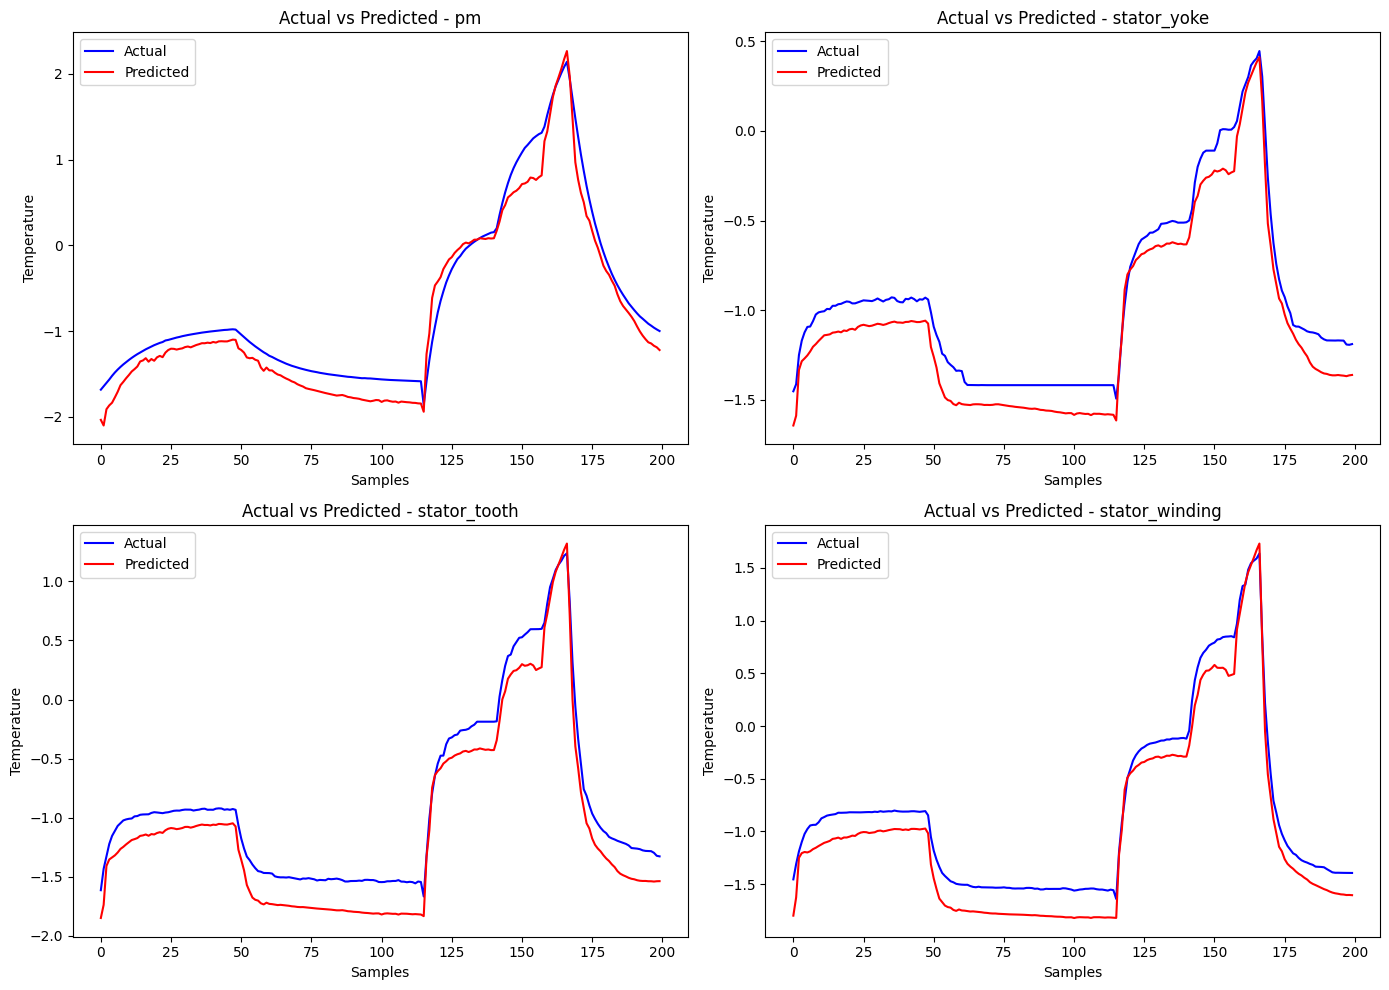

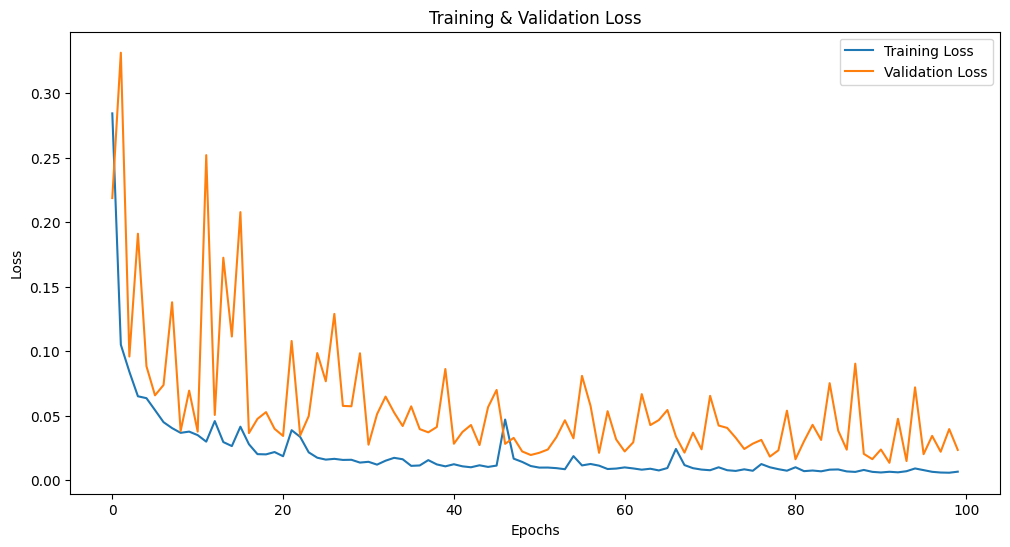

In [ ]:
# Evaluate the model
test_loss, test_mae = tft_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Predict
y_pred = tft_model.predict(X_test)

# Optional: inverse transform (if using scalers)
# y_pred = target_scaler.inverse_transform(y_pred)
# y_test = target_scaler.inverse_transform(y_test)

import pickle

# Save training history to a file
with open('tft_model_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Define your target column names
target_cols = ["pm", "stator_yoke", "stator_tooth", "stator_winding"]

# Plot predictions vs actuals for each temperature
plt.figure(figsize=(14, 10))
for i, col in enumerate(target_cols):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_test[:200, i], label='Actual', color='blue')
    plt.plot(y_pred[:200, i], label='Predicted', color='red')
    plt.title(f'Actual vs Predicted - {col}')
    plt.xlabel('Samples')
    plt.ylabel('Temperature')
    plt.legend()
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()


In [17]:
from tensorflow.keras.utils import plot_model

plot_model(tft_model, show_shapes=True, show_layer_names=True, to_file='tft_model.png')


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [18]:
import numpy as np
from sklearn.metrics import mean_squared_error

# model = 

def permutation_feature_importance(model, X_val, y_val, metric=mean_squared_error):
    baseline_preds = model.predict(X_val)
    baseline_score = metric(y_val, baseline_preds)

    importances = []

    for i in range(X_val.shape[2]):  # Loop through each feature
        X_val_permuted = X_val.copy()
        np.random.shuffle(X_val_permuted[:, :, i])  # Shuffle feature i across all samples
        permuted_preds = model.predict(X_val_permuted)
        permuted_score = metric(y_val, permuted_preds)
        
        importance = permuted_score - baseline_score
        importances.append(importance)

    return np.array(importances)


In [19]:
importances = permutation_feature_importance(tft_model, X_val, y_val)
for i, imp in enumerate(importances):
    print(f"Feature {i}: Importance = {imp:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


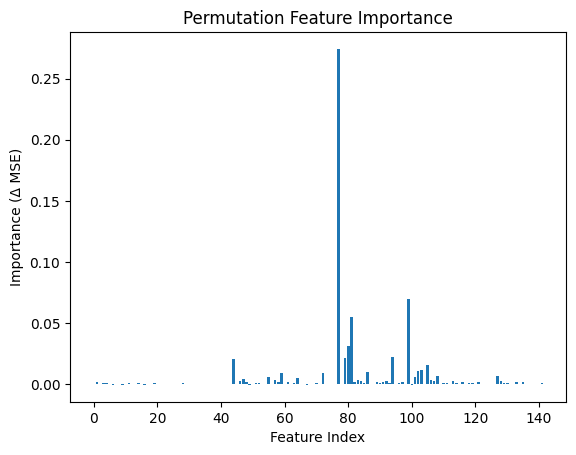

In [20]:
import matplotlib.pyplot as plt

plt.bar(range(len(importances)), importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance (Δ MSE)")
plt.title("Permutation Feature Importance")
plt.show()


In [21]:
import numpy as np

# Get indices of top 5 features (descending importance)
top_5_indices = np.argsort(importances)[::-1][:5]

# Print top 5
print("Top 5 important features (by index):")
for rank, idx in enumerate(top_5_indices, 1):
    print(f"{rank}. {x_cols[idx]} (index {idx}) - Importance: {importances[idx]:.4f}")


Top 5 important features (by index):
1. coolant_ew_rolling_mean_600 (index 77) - Importance: 0.2743
2. coolant_ew_rolling_mean_3600 (index 99) - Importance: 0.0699
3. i_d_ew_rolling_mean_600 (index 81) - Importance: 0.0550
4. motor_speed_ew_rolling_mean_600 (index 80) - Importance: 0.0311
5. profile_id_ew_rolling_std_600 (index 94) - Importance: 0.0225
